# 决策树

In [1]:
from math import log

## 计算给定数据集的香农熵

In [2]:
def calcShannonEnt(dataSet):
    '''
    给一个矩阵数据集，返回一个数，就是熵值。
    '''
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet: #the the number of unique elements and their occurance
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys(): labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob * log(prob, 2) #log base 2
    return shannonEnt

## 按照给定特征划分数据集

In [3]:
def splitDataSet(dataSet, axis, value):
    '''
    返回按照axis特征的value值划分的矩阵数据集
    '''
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]     #chop out axis used for splitting
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

## 选择最好的数据集划分方式

In [4]:
def chooseBestFeatureToSplit(dataSet):
    '''
    返回最优划分属性的axis
    '''
    numFeatures = len(dataSet[0]) - 1      #the last column is used for the labels
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0; bestFeature = -1
    for i in range(numFeatures):        #iterate over all the features
        featList = [example[i] for example in dataSet]#create a list of all the examples of this feature
        uniqueVals = set(featList)       #get a set of unique values
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)
        infoGain = baseEntropy - newEntropy     #calculate the info gain; ie reduction in entropy
        if (infoGain > bestInfoGain):       #compare this to the best gain so far
            bestInfoGain = infoGain         #if better than current best, set to best
            bestFeature = i
    return bestFeature

## 多数表决法决定该叶子节点的分类

In [5]:
def majorityCnt(classList):
    '''
    因为我们使用的id3算法，所以只需要在算法开始运行前计算列的数目，查看算法是否使用了所有属性即可
    适用情况→如果数据集已经处理了所有属性，但是类标签依然不是唯一的，此时我们需要决定如何定义该叶子节点，
    在这种情况下，我们通常会采用多数表决的方法决定该叶子节点的分类
    '''
    classCount={}
    for vote in classList:
        if vote not in classCount.keys(): classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]

## 递归构建决策树

In [6]:
def createTree(dataSet, labels):
    '''
    返回的嵌套字典
    '''
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList):
        return classList[0]#stop splitting when all of the classes are equal
    if len(dataSet[0]) == 1: #stop splitting when there are no more features in dataSet
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]       #copy all of labels, so trees don't mess up existing labels
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels)
    return myTree

## 使用决策树执行分类

In [7]:
def classify(inputTree, featLabels, testVec):
    firstStr = list(inputTree)[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    key = testVec[featIndex]
    valueOfFeat = secondDict[key]
    if isinstance(valueOfFeat, dict):
        classLabel = classify(valueOfFeat, featLabels, testVec)
    else: classLabel = valueOfFeat
    return classLabel

In [ ]:
dataset, labels = createDataSet() #label是特征的标签
myTree = createTree(dataSet, labels)
classify(myTree, labels, [1,0]) #对应labels的axis的value

In [13]:
fr = open('lenses.txt')
lenses = [inst.strip().split('\t') for inst in fr.readlines()]
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
lensesTree = createTree(lenses,lensesLabels)
print(lensesTree)

{'tearRate': {'normal': {'astigmatic': {'no': {'age': {'pre': 'soft', 'young': 'soft', 'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}}}}, 'yes': {'prescript': {'hyper': {'age': {'pre': 'no lenses', 'young': 'hard', 'presbyopic': 'no lenses'}}, 'myope': 'hard'}}}}, 'reduced': 'no lenses'}}


In [15]:
preds = []
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
for i in range(len(lenses)):
    pred = classify(lensesTree, lensesLabels, lenses[i][:-1])
    preds.append(pred)
print(preds)

['no lenses', 'soft', 'no lenses', 'hard', 'no lenses', 'soft', 'no lenses', 'hard', 'no lenses', 'soft', 'no lenses', 'hard', 'no lenses', 'soft', 'no lenses', 'no lenses', 'no lenses', 'no lenses', 'no lenses', 'hard', 'no lenses', 'soft', 'no lenses', 'no lenses']


隐形眼镜的例子表明决策树可能会产生过多的数据集划分，从而产生过度匹配数据集的问题。我们通过裁减决策树，合并相邻的无法产生大量信息增益的叶节点，消除过度匹配问题。

**这一章学的算法是结果确定的分类算法，数据实例最终会被明确划分到某个分类中。第四章我们讨论的分类算法（朴素贝叶斯）将不能完全确定数据实例应该划分到某个分类，或者只能给出数据实例属于给定分类的概率。**

ID3每次选取当前最佳特征来分割数据，切分过于迅速，除此之外还存在一个问题，他不能直接处理连续型特征。转换成离散型的话，会破坏连续型变量的内在性质。而使用二元切分法则易于对树构建过程进行调整以处理连续型特征。

# 树回归

In [16]:
from numpy import *
import matplotlib.pyplot as plt

## 回归树的叶节点生成函数

In [17]:
def regLeaf(dataSet):#returns the value used for each leaf
    return mean(dataSet[:,-1])

def regErr(dataSet):
    return var(dataSet[:,-1]) * shape(dataSet)[0]

## 模型树的叶节点生成函数

In [18]:
def linearSolve(dataSet):   #helper function used in two places
    m,n = shape(dataSet)
    X = mat(ones((m,n))); Y = mat(ones((m,1)))#create a copy of data with 1 in 0th postion
    X[:,1:n] = dataSet[:,0:n-1]; Y = dataSet[:,-1]#and strip out Y
    xTx = X.T*X
    if linalg.det(xTx) == 0.0:
        raise NameError('This matrix is singular, cannot do inverse,\n\
        try increasing the second value of ops')
    ws = xTx.I * (X.T * Y)
    return ws,X,Y

def modelLeaf(dataSet):#create linear model and return coeficients
    ws,X,Y = linearSolve(dataSet)
    return ws

def modelErr(dataSet):
    ws,X,Y = linearSolve(dataSet)
    yHat = X * ws
    return sum(power(Y - yHat,2))

## 树的生成函数

In [19]:
def binSplitDataSet(dataSet, feature, value):
    mat0 = dataSet[nonzero(dataSet[:,feature] > value)[0],:]
    mat1 = dataSet[nonzero(dataSet[:,feature] <= value)[0],:]
    return mat0,mat1

def chooseBestSplit(dataSet, leafType=regLeaf, errType=regErr, ops=(1,4)):
    tolS = ops[0]; tolN = ops[1]  #容许的误差下降值，容许的切分最少样本数
    #if all the target variables are the same value: quit and return value
    if len(set(dataSet[:,-1].T.tolist()[0])) == 1: #exit cond 1
        return None, leafType(dataSet)
    m,n = shape(dataSet)
    #the choice of the best feature is driven by Reduction in RSS error from mean
    S = errType(dataSet)
    bestS = inf; bestIndex = 0; bestValue = 0
    for featIndex in range(n-1):
        for splitVal in set(dataSet[:,featIndex].T.tolist()[0]):
            mat0, mat1 = binSplitDataSet(dataSet, featIndex, splitVal)
            if (shape(mat0)[0] < tolN) or (shape(mat1)[0] < tolN): continue
            newS = errType(mat0) + errType(mat1)
            if newS < bestS: 
                bestIndex = featIndex
                bestValue = splitVal
                bestS = newS
    #if the decrease (S-bestS) is less than a threshold don't do the split
    if (S - bestS) < tolS: 
        return None, leafType(dataSet) #exit cond 2
    mat0, mat1 = binSplitDataSet(dataSet, bestIndex, bestValue)
    if (shape(mat0)[0] < tolN) or (shape(mat1)[0] < tolN):  #exit cond 3
        return None, leafType(dataSet)
    return bestIndex,bestValue#returns the best feature to split on
                              #and the value used for that split

def createTree(dataSet, leafType=regLeaf, errType=regErr, ops=(1,4)):#assume dataSet is NumPy Mat so we can array filtering
    feat, val = chooseBestSplit(dataSet, leafType, errType, ops)#choose the best split
    if feat == None: return val #if the splitting hit a stop condition return val
    retTree = {}
    retTree['spInd'] = feat
    retTree['spVal'] = val
    lSet, rSet = binSplitDataSet(dataSet, feat, val)
    retTree['left'] = createTree(lSet, leafType, errType, ops)
    retTree['right'] = createTree(rSet, leafType, errType, ops)
    return retTree

## 用树回归进行预测的代码

In [20]:
def isTree(obj):
    return (type(obj).__name__=='dict')

def regTreeEval(model, inDat):
    return float(model)

def modelTreeEval(model, inDat):
    n = shape(inDat)[1]
    X = mat(ones((1,n+1)))
    X[:,1:n+1]=inDat
    return float(X*model)

def treeForeCast(tree, inData, modelEval=regTreeEval):
    if not isTree(tree): return modelEval(tree, inData)
    if inData[tree['spInd']] > tree['spVal']:
        if isTree(tree['left']): return treeForeCast(tree['left'], inData, modelEval)
        else: return modelEval(tree['left'], inData)
    else:
        if isTree(tree['right']): return treeForeCast(tree['right'], inData, modelEval)
        else: return modelEval(tree['right'], inData)
        
def createForeCast(tree, testData, modelEval=regTreeEval):
    m=len(testData)
    yHat = mat(zeros((m,1)))
    for i in range(m):
        yHat[i,0] = treeForeCast(tree, mat(testData[i]), modelEval)
    return yHat

## 导入数据

In [21]:
def loadDataSet(fileName):      #general function to parse tab -delimited floats
    dataMat = []                #assume last column is target value
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        fltLine = list(map(float,curLine)) #map all elements to float()
        dataMat.append(fltLine)
    return dataMat

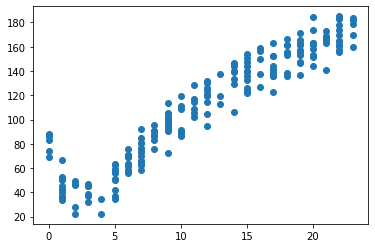

In [22]:
trainMat = mat(loadDataSet('bikeSpeedVsIq_train.txt'))
testMat = mat(loadDataSet('bikeSpeedVsIq_test.txt'))
plt.scatter(array(trainMat[:,0]), array(trainMat[:,1]))
plt.show()

## 回归树预测

In [23]:
myTree = createTree(trainMat, ops=(1,20))
yHat = createForeCast(myTree, testMat[:, 0])
corrcoef(yHat, testMat[:, 1], rowvar=0)[0,1]

0.96408523182221406

## 模型树预测

In [24]:
myTree = createTree(trainMat, modelLeaf, modelErr, ops=(1,20))
yHat = createForeCast(myTree, testMat[:,0],modelTreeEval)
corrcoef(yHat, testMat[:, 1], rowvar=0)[0,1]

0.9760412191380593